In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob
from pathlib import Path
import re
import warnings
import matplotlib.pyplot as plt
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates
sys.path.append('src')
# from src.non_snow_retrievals import canopy_permittivity, vegetation_phase
from src.swe_retrievals import *

warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter('ignore', SettingWithCopyWarning)


In [74]:
def compile_timeseries(station_id, time='am'):
    sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
    site = sites.loc[sites['station_id']==station_id]
    df = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/snotel/hourly/{station_id}_hourly_2016_2025.csv',
                    index_col=0, parse_dates=True)
    df.index = df.index.tz_convert(site['timezone'].values[0]).tz_localize(None)
    
    
    if time == 'am':
        df_out = pd.DataFrame(df.loc[df.index.hour==6, 'SOIL MOISTURE -2IN'])
    elif time == 'pm':
        df_out = pd.DataFrame(df.loc[df.index.hour==18, 'SOIL MOISTURE -2IN'])
        
    for i in df_out.index:
        if pd.isnull(df_out.loc[i, 'SOIL MOISTURE -2IN']):
            try:
                if pd.notnull(df.loc[i-pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']):
                    df_out.loc[i, 'SOIL MOISTURE -2IN'] = df.loc[i-pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']
            except KeyError:
                pass
        if pd.isnull(df_out.loc[i, 'SOIL MOISTURE -2IN']):
            try:
                if pd.notnull(df.loc[i+pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']):
                    df_out.loc[i, 'SOIL MOISTURE -2IN'] = df.loc[i+pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']
            except KeyError:
                pass
        
    # Keep temp, swe, SM columns from snotel data
    if df.iloc[0]['AIR TEMP_units'] == 'degF':
        df_out['airtemp_C'] = (df.loc[df_out.index, 'AIR TEMP'] - 32)*5/9
    else:
        df_out['airtemp_C'] = df.loc[df_out.index, 'AIR TEMP']
    
    df_out['swe_m'] = df.loc[df_out.index, 'SWE'] * 0.0254
    df_out.rename(columns={'SOIL MOISTURE -2IN':'soil_moisture_pct'}, inplace=True)
    
    
    # Dry atmosphere
    dry_atmo = xr.open_dataset(f'/pl/active/palomaki-sar/insar_swe_errors/data/atmo_dry/pressure_{time}.nc').sel(lat=site['lat'].values[0], lon=site['lon'].values[0], method='nearest')
    dry_atmo['time'] = dry_atmo['time'] - pd.to_timedelta('6h')
    df_out['surf_pres'] = dry_atmo.to_dataframe()['PS']
    
    # Wet atmosphere
    wet_atmo = xr.open_dataset(f'/pl/active/palomaki-sar/insar_swe_errors/data/atmo_wet/pw_{time}.nc').sel(lat=site['lat'].values[0], lon=site['lon'].values[0], method='nearest')
    wet_atmo['time'] = wet_atmo['time'] - pd.to_timedelta('6h')
    df_out['precip_water'] = wet_atmo.to_dataframe()['TQV']
    
    # Ionosphere
    ion = xr.open_dataset(f'/pl/active/palomaki-sar/insar_swe_errors/data/ionosphere/ion_{time}.nc').sel(y=site['lat'].values[0], x=site['lon'].values[0], method='nearest')
    # Ionosphere data is saved at the correct local hour for am/pm but does not have hour attached
    # Add hour into timestamp (instead of subtracting from UTC)
    if time == 'am':
        timedelta = 6
    elif time == 'pm':
        timedelta = 18
    ion['time'] = ion['time'] + pd.to_timedelta(timedelta, 'h')
    df_out['ion_tec'] = ion.to_dataframe()['__xarray_dataarray_variable__']
    
    return df_out
    

sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
for station in sites['station_id']:
    for time in ['am','pm']:
        data = compile_timeseries(station, time=time)
        data.to_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/compiled/{station}_{time}.csv')

In [73]:
station_id=1000
time='am'

sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
site = sites.loc[sites['station_id']==station_id]
df = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/snotel/hourly/{station_id}_hourly_2016_2025.csv',
                index_col=0, parse_dates=True)
df.index = df.index.tz_convert(site['timezone'].values[0]).tz_localize(None)

if time == 'am':
    df_out = pd.DataFrame(df.loc[df.index.hour==6, 'SOIL MOISTURE -2IN'])
elif time == 'pm':
    df_out = pd.DataFrame(df.loc[df.index.hour==18, 'SOIL MOISTURE -2IN'])

for i in df_out.index:
    if pd.isnull(df_out.loc[i, 'SOIL MOISTURE -2IN']):
        try:
            if pd.notnull(df.loc[i-pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']):
                df_out.loc[i, 'SOIL MOISTURE -2IN'] = df.loc[i-pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']
        except KeyError:
            pass
    if pd.isnull(df_out.loc[i, 'SOIL MOISTURE -2IN']):
        try:
            if pd.notnull(df.loc[i+pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']):
                df_out.loc[i, 'SOIL MOISTURE -2IN'] = df.loc[i+pd.to_timedelta('1h'), 'SOIL MOISTURE -2IN']
        except KeyError:
            pass

## Figure 1 - SWE curves and error comparison

In [3]:
def calc_all_errors(df, site):
    # Calculate errors from pre-compiled data
    # Soil moisture
    df['soil_error'] = calc_soil_moisture_error(sand=site['sand']/10, 
                                                clay=site['clay']/10, 
                                                sm_series=df['soil_moisture_pct']/100)
    # Veg permittivity changes
    df['veg_error'] = calc_veg_permittivity_error(canopy_height=site['canopy_height'].values[0], 
                                                  temperature_series=df['airtemp_C'])
    # Dry atmosphere
    df['dry_atmo_error'] = calc_dry_atmo_error(pressure_series=df['surf_pres'])
    # Wet atmosphere
    df['wet_atmo_error'] = calc_wet_atmo_error(pw_series=df['precip_water']/1000)
    # Ionosphere
    df['ion_error'] = calc_ionosphere_error(tec_series=df['ion_tec'])
    # Surface deformation
    
    # Total error
    df['total_error'] = df[['soil_error','veg_error','dry_atmo_error','wet_atmo_error','ion_error']].sum(axis=1,min_count=1)
    df['non_ion_error'] = df[['soil_error','veg_error','dry_atmo_error','wet_atmo_error']].sum(axis=1,min_count=1)
    
    return df    


def plot_swe_curves(station_id: int, wateryear: int, time: str = 'am', ax1=None,
                    ax2=None, plot_type: str = 'total_error', return_data: bool = True):
    """
    679	Paradise
    398	Clackamas Lake
    1000	Annie Springs
    846	Virginia Lakes Rdg
    821	Tipton
    759	Silvies
    417	Corral Canyon
    803	Sunset
    490	Galena Summit
    577	Lewis Lake Divide
    828	Trial Lake
    935	Jackwhacker Gulch
    708	Quemazon
    """
    sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
    site = sites.loc[sites['station_id']==station_id]
    df = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/compiled/{station_id}_{time}.csv',
                     index_col=0, parse_dates=True)
    # Subset for water year
    df['wateryear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in df.index]
    df = df.loc[df['wateryear']==wateryear]
    df = df.loc[:f'{wateryear}-07-01']
    
    df = calc_all_errors(df, site)
    
    if plot_type == 'total_error':
        # Total error plot
        df['swe_m'].plot(ax=ax1, lw=1.5, label='SNOTEL')
#         (df['total_error'] + df['swe_m']).plot(ax=ax1, color='k', alpha=0.5, lw=0.7, label='SNOTEL + all errors')
        (df['non_ion_error'] + df['swe_m']).plot(ax=ax1, label='SNOTEL + errors')
        
        ax1.set_title(f'{site["station_name"].values[0]} {wateryear}')
        ax1.set_xlabel('')
        ax1.set_ylabel('SWE [m]')
        ax1.xaxis.set_major_locator(mdates.MonthLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
        ax1.legend()
        
        # Error components
        percent_error = pd.DataFrame(index=df.index)
        for c in ['soil_error','veg_error','dry_atmo_error','wet_atmo_error','ion_error']:
            percent_error[c] = df[c]/df['swe_m']*100
            
        percent_error.loc[df['swe_m'] < 0.1] = np.nan
        percent_error['soil_error'].plot(ax=ax2, label='Soil moisture')
        percent_error['veg_error'].plot(ax=ax2, label='Veg permittivity')
        percent_error['dry_atmo_error'].plot(ax=ax2, label='Dry atmosphere', alpha=0.5)
        percent_error['wet_atmo_error'].plot(ax=ax2, label='Wet atmosphere', alpha=0.5)
#         percent_error['ion_error'].plot(ax=ax2, label='Ionosphere')
#         ax.set_title(f'{site["station_name"].values[0]} {wateryear}')

        ax2.hlines([-10,10], f'{wateryear-1}-10-01', f'{wateryear}-07-01', lw=1.5, color='k', ls='--')
        
        ax2.set_title(f'{site["station_name"].values[0]} {wateryear}')
        ax2.set_xlabel('')
        ax2.set_xlim(ax1.get_xlim())
        ax2.xaxis.set_major_locator(mdates.MonthLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center')
#         ax2.set_ylim([-100,50])
        ax2.set_ylabel('SWE error [% of SWE on the ground]')
        ax2.legend()
        
    elif plot_type == 'individual':
        if ax1 is None:
            fig, ax1 = plt.subplots(figsize=(6,6))
        
#         df['swe_m'].plot(ax=ax1, label='SNOTEL')
        (df['dry_atmo_error'] + df['swe_m']).plot(ax=ax1, label='Dry atmosphere', alpha=0.6)
        (df['wet_atmo_error'] + df['swe_m']).plot(ax=ax1, label='Wet atmosphere', alpha=0.6)
        (df['soil_error'] + df['swe_m']).plot(ax=ax1, label='Soil moisture')
        (df['veg_error'] + df['swe_m']).plot(ax=ax1, label='Veg permittivity')
        
#         (df['ion_error'] + df['swe_m']).plot(ax=ax1, label='Ionosphere')
    
        ax1.set_title(f'{site["station_name"].values[0]} WY{wateryear}')
        ax1.set_xlabel('')
        ax1.set_ylabel('SWE [m]')
        ax1.legend()
    
    if return_data:
        return df


# for axx in ax.flatten():
#     axx.set_ylim([-0.02, 1.02]

/tmp/ipykernel_906641/2748868719.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
/tmp/ipykernel_906641/2748868719.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center')
/tmp/ipykernel_906641/2748868719.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
/tmp/ipykernel_906641/2748868719.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center')
/tmp/ipykernel_906641/2748868719.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
/tmp/ipykernel_906641/2748868719.py:87: UserWarning: FixedFormatter should 

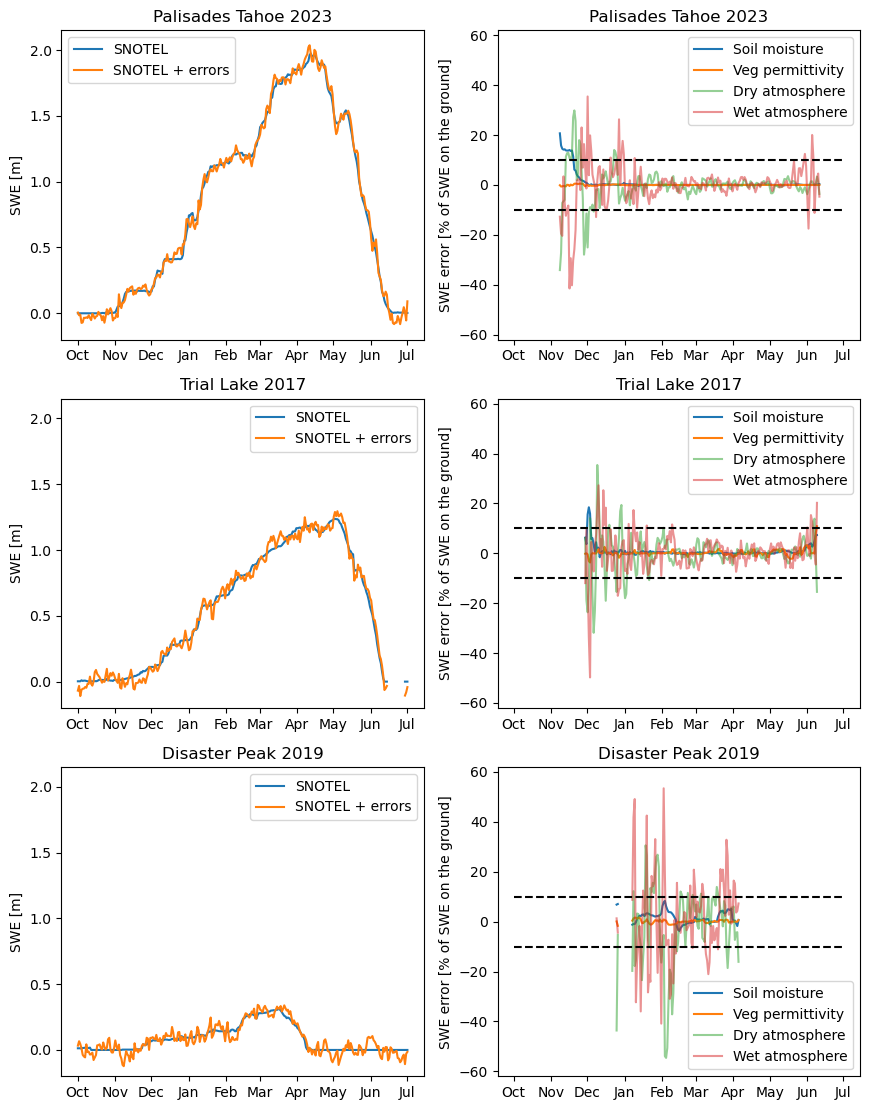

In [3]:
station_id = 1000
wateryear = 2023

sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
site = sites.loc[sites['station_id']==station_id]
# df = plot_swe_curves(station_id=station_id, wateryear=wateryear)

# 1000 2023

fig, ax = plt.subplots(3, 2, figsize=(11*0.8,14*0.8))
test = plot_swe_curves(station_id=784, wateryear=2023, ax1=ax[0,0], ax2=ax[0,1], return_data=True)
plot_swe_curves(station_id=828, wateryear=2017, ax1=ax[1,0], ax2=ax[1,1], return_data=False)
plot_swe_curves(station_id=445, wateryear=2019, ax1=ax[2,0], ax2=ax[2,1], return_data=False)
ymin = min([ax.get_ylim()[0] for ax in ax[0]])
ymax = max([ax.get_ylim()[1] for ax in ax[0]])
for axx in ax[:,0]:
    axx.set_ylim([-0.2, 2.15])
for axx in ax[:,1]:
    axx.set_ylim([-62, 62])
    
plt.tight_layout()
# plt.show()



# for s_id in sites['station_id']:
#     fig, ax = plt.subplots(2, 5, figsize=(20,8))
#     for i, year in enumerate(range(2016,2026)):
#         plot_swe_curves(station_id=s_id, wateryear=year, plot_type='individual', ax1=ax.flatten()[i], return_data=False)
    
#     plt.tight_layout()
#     fig.savefig(f'local/figs/{s_id}_allyears.png', dpi=300)
#     plt.close()
    
# plt.tight_layout()

In [4]:
fig.savefig('fig1_all_but_ion.png', dpi=300)

# percent_error = test[['soil_error','veg_error','dry_atmo_error','wet_atmo_error','ion_error']]/test['swe_m']*100
# percent_error#.loc[df['swe_m'] < 0.1] = np.nan

## Figure 2 - Temporal variability

In [4]:
def make_temp_var_plot(ax, df_am, df_pm, error_col, site, n_wy_days=274, plot_pm=False):
    c = error_col
    plot_titles = {'soil_error':'Soil moisture error','veg_error':'Veg permittivity error','dry_atmo_error':'Dry atmosphere error','wet_atmo_error':'Wet atmosphere error','ion_error':'Ionospheric error'}
    am_gb = df_am.loc[df_am['dowy']<=n_wy_days].groupby('dowy')
    pm_gb = df_pm.loc[df_pm['dowy']<=n_wy_days].groupby('dowy')

    month_starts = [1,32,62,93,124,152,183,213,244,274] # Through July

    ax.fill_between(am_gb.quantile(0.1)[c].index, df_am.loc[df_am['dowy']<=n_wy_days].groupby('dowy').quantile(0.1)[c].rolling(7).mean(), df_am.loc[df_am['dowy']<=n_wy_days].groupby('dowy').quantile(0.9)[c].rolling(7).mean(), alpha=0.4, color=plt.get_cmap('tab10')(0), label='AM orbit')
    ax.plot(am_gb.median()[c].rolling(7).mean(), lw=2)
    ax.plot(am_gb.quantile(0.1)[c].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))
    ax.plot(am_gb.quantile(0.9)[c].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(0))
    
    if plot_pm:
        ax.fill_between(pm_gb.quantile(0.1)[c].index, df_pm.loc[df_pm['dowy']<=n_wy_days].groupby('dowy').quantile(0.1)[c].rolling(7).mean(), df_pm.loc[df_pm['dowy']<=n_wy_days].groupby('dowy').quantile(0.9)[c].rolling(7).mean(), alpha=0.5, color=plt.get_cmap('tab10')(1), label='PM orbit')
        ax.plot(pm_gb.median()[c].rolling(7).mean(), lw=2, color=plt.get_cmap('tab10')(1))
        ax.plot(pm_gb.quantile(0.1)[c].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))
        ax.plot(pm_gb.quantile(0.9)[c].rolling(7).mean(), lw=1, alpha=0.8, color=plt.get_cmap('tab10')(1))
        ax.legend()
    
    ax.set_xticks(month_starts)
    ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul'])
    if c == 'soil_error':
        ax.set_title(site['station_name'].values[0] + '\n\n' + plot_titles[c])
    else:
        ax.set_title(plot_titles[c])


def plot_temporal_variability(station_id: int, ax: plt.axes = None, return_data: bool = True):
    """
    679	Paradise
    398	Clackamas Lake
    1000	Annie Springs
    846	Virginia Lakes Rdg
    821	Tipton
    759	Silvies
    417	Corral Canyon
    803	Sunset
    490	Galena Summit
    577	Lewis Lake Divide
    828	Trial Lake
    935	Jackwhacker Gulch
    708	Quemazon
    """
    sites = pd.read_csv('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
    site = sites.loc[sites['station_id']==station_id]
    df_am = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/compiled/{station_id}_am.csv',
                     index_col=0, parse_dates=True)
    df_pm = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/compiled/{station_id}_pm.csv',
                     index_col=0, parse_dates=True)
    
    df_am = calc_all_errors(df_am, site)
    df_pm = calc_all_errors(df_pm, site)
    
    
    for df in [df_am, df_pm]:
    # Subset for water year
        df['wateryear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in df.index]
        df['dowy'] = [(r[0] - pd.to_datetime(f'{int(r[1]["wateryear"])-1}-10-01')) for r in df.iterrows()] # type: ignore
        df['dowy'] = df['dowy'].dt.days + 1


    # Plot
    if ax is None:
        fig, ax = plt.subplots(5, 1, figsize=(5,20))
    error_cols = ['soil_error','veg_error','dry_atmo_error','wet_atmo_error','ion_error']
    for i, c in enumerate(error_cols):
        if c == 'ion_error':
            make_temp_var_plot(ax[i], df_am, df_pm, c, site, plot_pm=True)
        else:
            make_temp_var_plot(ax[i], df_am, df_pm, c, site, plot_pm=False)
        
        
    if return_data:
        return (df_am, df_pm)





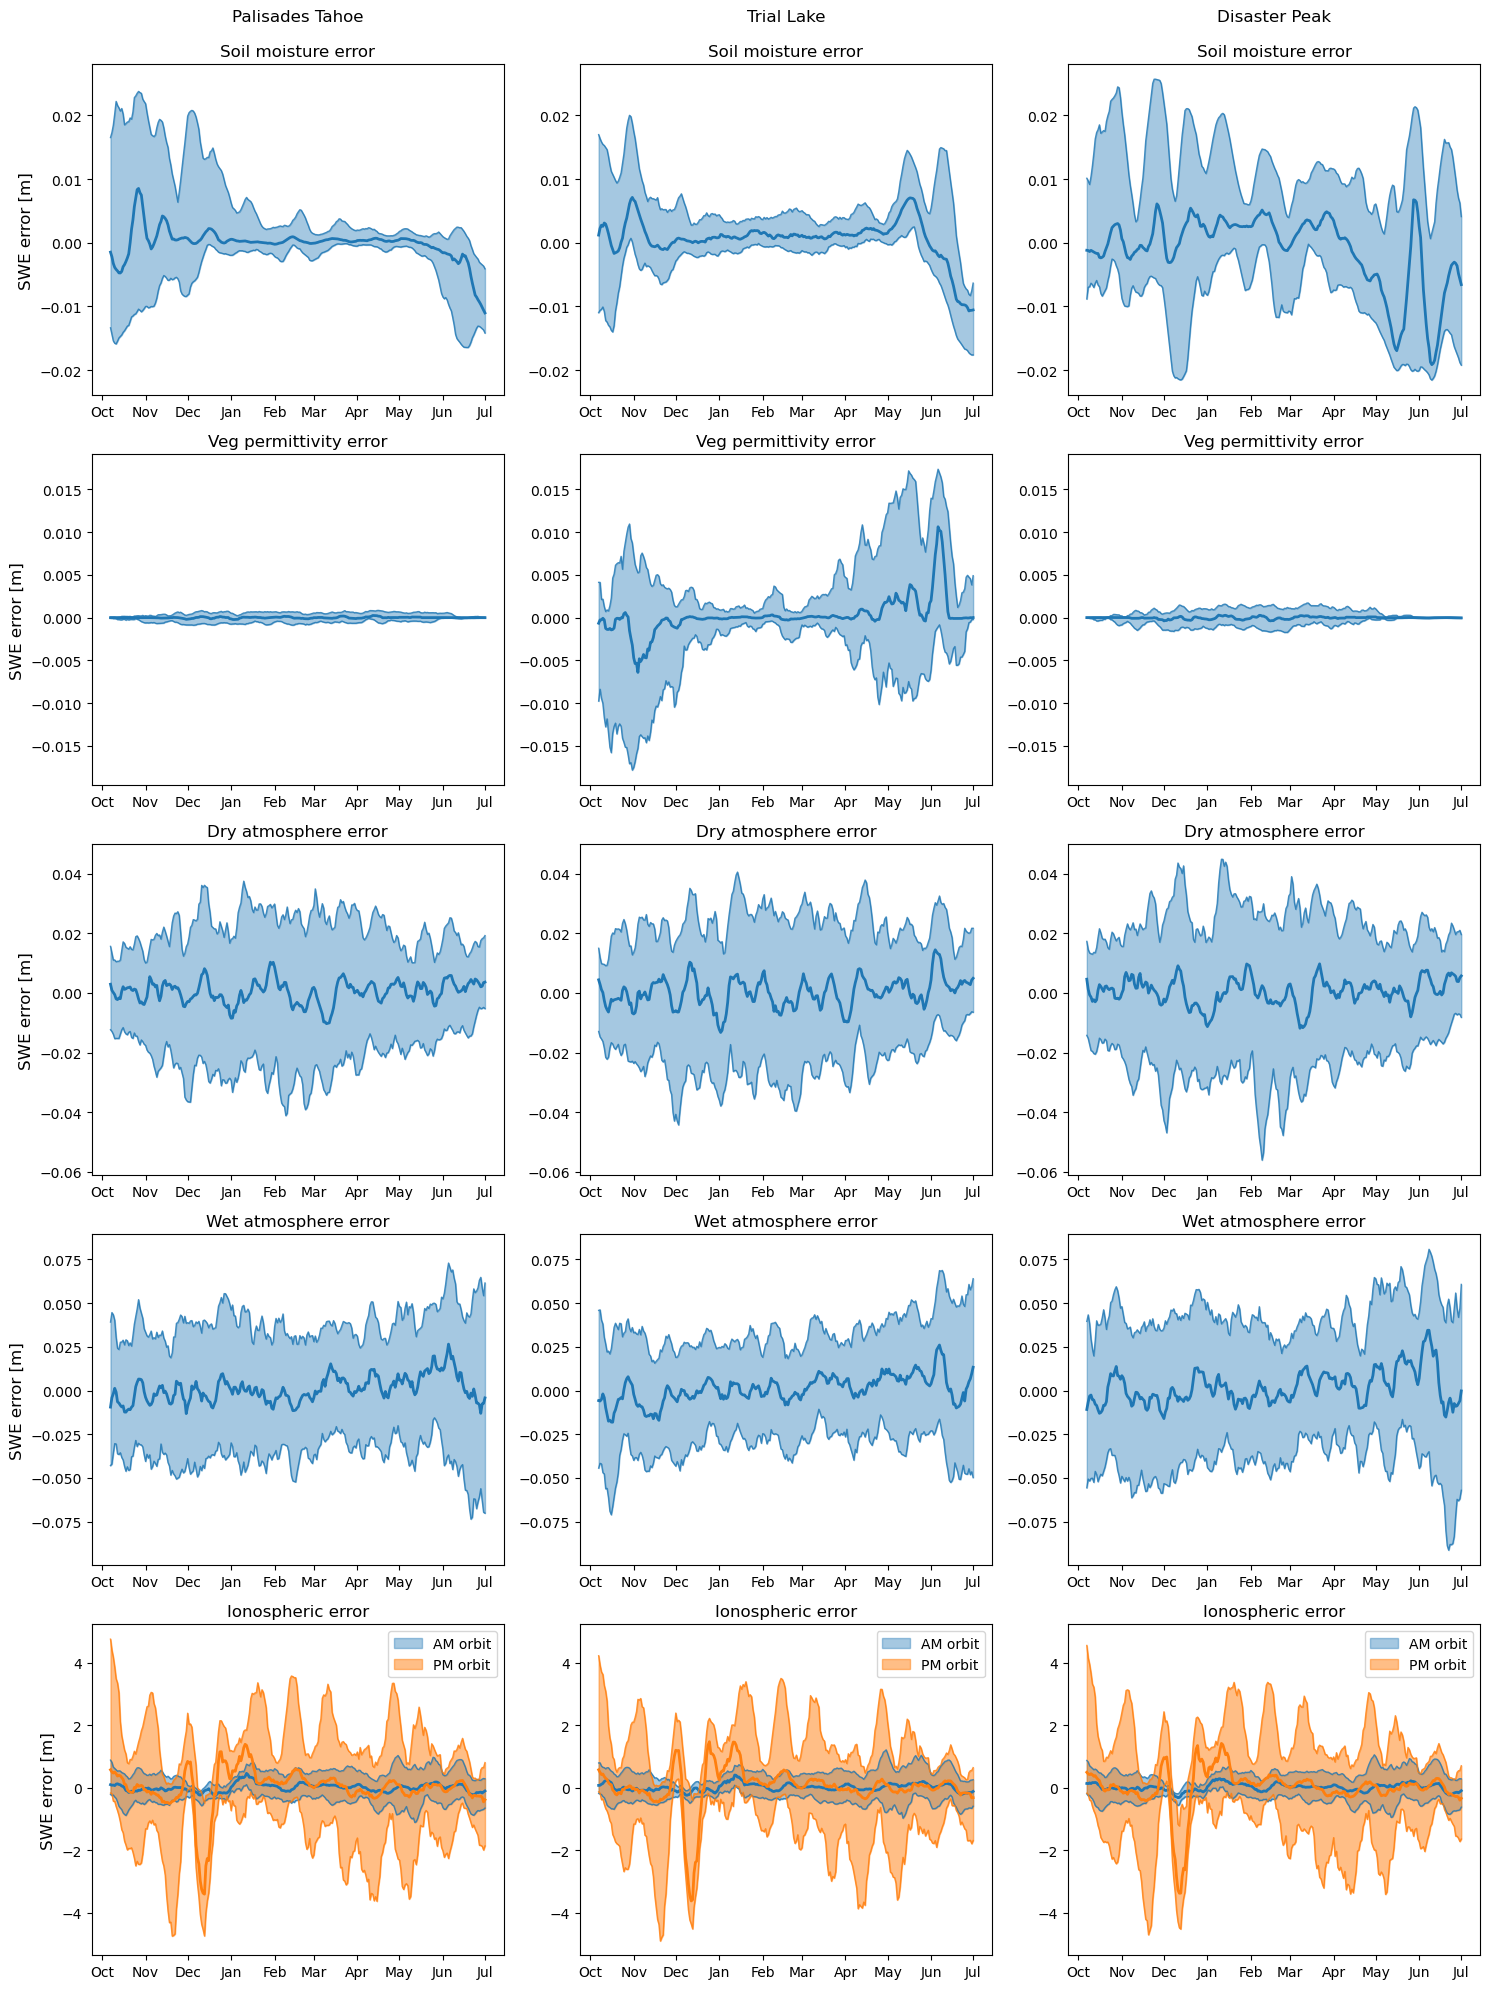

In [131]:
fig, ax = plt.subplots(5, 3, figsize=(15,20))
plot_temporal_variability(station_id=784, ax=ax[:,0], return_data=False)
plot_temporal_variability(station_id=828, ax=ax[:,1], return_data=False)
plot_temporal_variability(station_id=445, ax=ax[:,2], return_data=False)
for i in range(5):
    miny = min([a.get_ylim()[0] for a in ax[i]])
    maxy = max([a.get_ylim()[1] for a in ax[i]])
    for axx in ax[i]: 
        axx.set_ylim(miny, maxy)

for axx in ax[:,0]:
    axx.set_ylabel('SWE error [m]', fontsize=12)
plt.tight_layout()

In [132]:
fig.savefig('fig2.png', dpi=300)

## Calculate median error for all types at all sites

In [5]:
sites = gpd.read_file('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv')
for c in ['station_id','lat', 'lon', 'sand', 'clay','sturm', 'landfire', 'canopy_height']:
    sites[c] = pd.to_numeric(sites[c])
sites['median_peak_swe'] = np.nan
sites['median_soil_error'] = np.nan
sites['median_veg_error'] = np.nan
sites['median_wet_error'] = np.nan
sites['median_dry_error'] = np.nan
sites['median_ion_error'] = np.nan

for station_id in sites['station_id']:
    site = sites.loc[sites['station_id']==station_id]
    df = pd.read_csv(f'/pl/active/palomaki-sar/insar_swe_errors/data/compiled/{station_id}_am.csv',
                     index_col=0, parse_dates=True)
    df['wateryear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in df.index]

    df = calc_all_errors(df, site)
    for c in ['soil_error','veg_error','dry_atmo_error','wet_atmo_error','ion_error']:
        df[c] = df[c].abs()
    
    sites.loc[sites['station_id']==station_id, 'median_peak_swe'] = float(df[['wateryear','swe_m']].groupby('wateryear').max().median()['swe_m'])
    sites.loc[sites['station_id']==station_id, 'median_soil_error'] = float(df[['wateryear','soil_error']].groupby('wateryear').median().median()['soil_error'])
    sites.loc[sites['station_id']==station_id, 'median_veg_error'] = float(df[['wateryear','veg_error']].groupby('wateryear').median().median()['veg_error'])
    sites.loc[sites['station_id']==station_id, 'median_dry_error'] = float(df[['wateryear','dry_atmo_error']].groupby('wateryear').median().median()['dry_atmo_error'])
    sites.loc[sites['station_id']==station_id, 'median_wet_error'] = float(df[['wateryear','wet_atmo_error']].groupby('wateryear').median().median()['wet_atmo_error'])
    sites.loc[sites['station_id']==station_id, 'median_ion_error'] = float(df[['wateryear','ion_error']].groupby('wateryear').median().median()['ion_error'])

sites.drop(columns=['geometry'], inplace=True)
sites.to_csv('local/median_errors.csv', index=False)

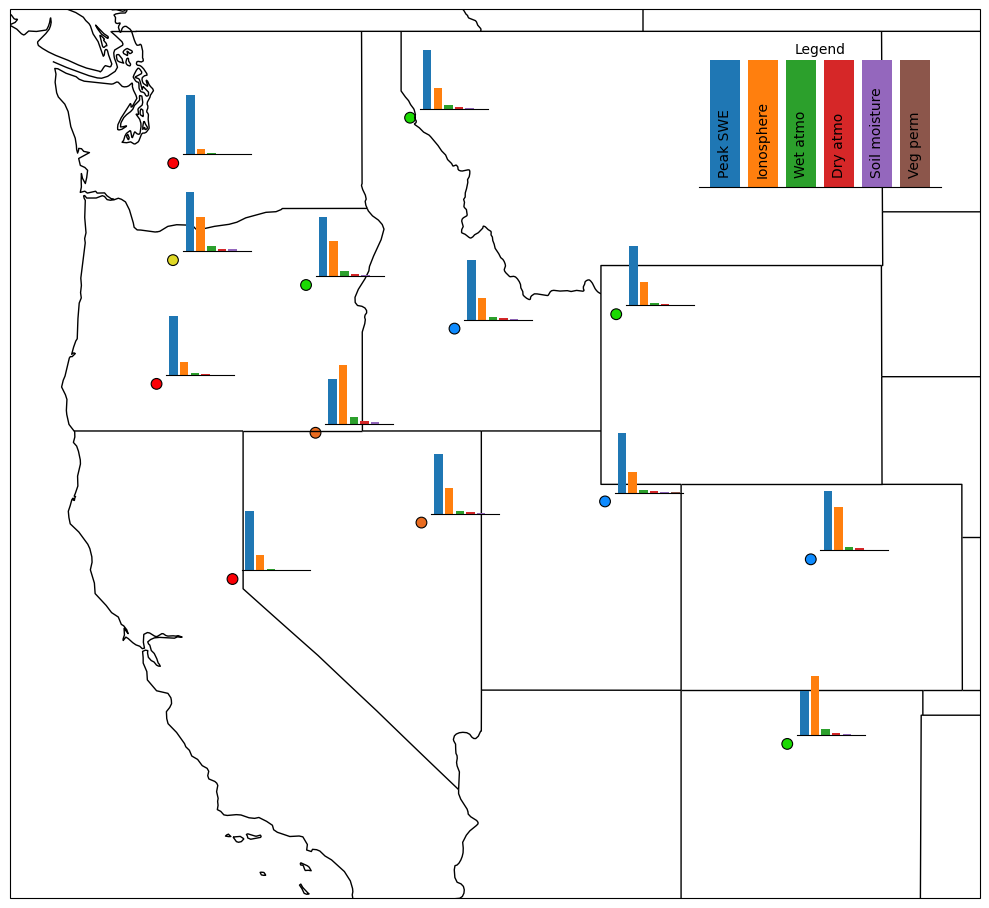

In [9]:
# sites = gpd.read_file('/pl/active/palomaki-sar/insar_swe_errors/data/snotel/fig4_sites.csv', geometry='geometry')
sites = gpd.read_file('local/median_errors.csv')
for c in sites.columns:
    try:
        sites[c] = pd.to_numeric(sites[c])
    except:
        continue
        
sites['geometry'] = gpd.points_from_xy(sites['lon'], sites['lat'], crs='epsg:4326')
sites = gpd.GeoDataFrame(sites).to_crs('epsg:3857')
sites = sites.loc[sites['ecoregion']!='']

countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.epsg(3857))
ax.coastlines()
# ax.
ax.add_feature(countries)
ax.add_feature(states_provinces)
minx, miny, maxx, maxy = sites.total_bounds
minx *= 1.03
maxx *= 0.96
miny *= 0.9
maxy *= 1.05
ax.set_extent((minx, maxx, miny, maxy), crs=ccrs.epsg(3857))

color_dict = {1:'#8d00bb',2:'#0e8bff',3:'#fb0006',4:'#dfd826',5:'#e96c20',6:'#1bda02',7:'#9a9a9a'}
sturm_colors = [color_dict[x] for x in sites['sturm']]
sites['sturm_colors'] = sturm_colors

sites['geometry'].plot(ax=ax, color=sites['sturm_colors'], markersize=60, edgecolor='k', linewidth=0.8)

sites['ax_x'] = (sites['geometry'].x - minx) / (maxx-minx)
sites['ax_y'] = (sites['geometry'].y - miny) / (maxy-miny)
colors = [plt.get_cmap('tab10')(i) for i in range(6)]

for i, site in sites.iterrows():
    rel_errors = site[['median_peak_swe','median_ion_error','median_wet_error','median_dry_error','median_soil_error','median_veg_error']]/site['median_peak_swe']
    ax_mini = ax.inset_axes([site['ax_x']+0.01, site['ax_y']+0.01, 0.07, 0.07], transform=ax.transAxes)
    ax_mini.patch.set_alpha(0.0)
    ax_mini.spines[['top','right','left']].set_visible(False)
    ax_mini.bar(np.arange(6), rel_errors, color=colors)
    ax_mini.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
                            
ax_legend = ax.inset_axes([0.71, 0.8, 0.25, 0.15], transform=ax.transAxes)
ax_legend.patch.set_alpha(0.0)
# ax_legend.patch.set_alpha(0.0)
ax_legend.spines[['top','right','left']].set_visible(False)
ax_legend.bar(np.arange(6), np.tile(1,6), color=colors)
ax_legend.text(0.5, 1, 'Legend', ha='center', transform=ax_legend.transAxes)
ax_legend.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
for i, text in enumerate(['Peak SWE','Ionosphere','Wet atmo','Dry atmo','Soil moisture','Veg perm']):
    ax_legend.text(i-0.18, 0.1, text, rotation=90)
    
# sturm = rxr.open_rasterio('/pl/active/palomaki-sar/insar_swe_errors/data/ancillary/SnowClass_NA_01km_30.0arcsec_2021_v01.0.tif').rio.reproject('epsg:3857').rio.clip_box(minx, miny, maxx, maxy)
# sturm = sturm.where(sturm<8)
# sturm.plot(ax=ax, zorder=0)
    
plt.tight_layout()
# fig.savefig('map_test.png', dpi=300)

In [10]:
sites

,ecoregion,station_name,station_id,lat,lon,elev,sand,clay,sturm,landfire,...,median_peak_swe,median_soil_error,median_veg_error,median_wet_error,median_dry_error,median_ion_error,geometry,sturm_colors,ax_x,ax_y
0,North Cascades,Paradise,679,46.78266,-121.74767,1570,748,19,3,119,...,2.03962,0.006966,0.002309,0.034153,0.014438,0.178453,POINT (-13552888.630 5906670.527),#fb0006,0.168289,0.826917
1,Cascades,Clackamas Lake,398,45.09658,-121.75443,1036,524,164,4,124,...,0.36195,0.010882,0.001124,0.034897,0.013526,0.210319,POINT (-13553641.149 5636738.867),#dfd826,0.168010,0.717808
2,Eastern Cascades,Annie Springs,1000,42.87007,-122.16518,1835,705,24,3,127,...,1.12014,0.003627,0.004635,0.029884,0.012471,0.242186,POINT (-13599365.630 5292216.040),#fb0006,0.151078,0.578550
3,Sierra Nevada,Palisades Tahoe,784,39.18986,-120.26576,2441,450,150,3,205,...,1.01473,0.002288,0.000032,0.026793,0.010939,0.267679,POINT (-13387923.163 4748903.992),#fb0006,0.229376,0.358939
4,Blue Mountains,Tipton,821,44.65567,-118.42617,1570,386,95,6,120,...,0.36703,0.004576,0.001219,0.031110,0.013396,0.216692,POINT (-13183140.941 5567475.687),#1bda02,0.305208,0.689812
5,Northern Basin and Range,Disaster Peak,445,41.96737,-118.18934,1908,450,150,5,210,...,0.18542,0.006570,0.000047,0.028624,0.012818,0.242186,POINT (-13156777.146 5156092.881),#e96c20,0.314971,0.523528
6,Central Basin and Range,Corral Canyon,417,40.27551,-115.54017,2573,430,190,5,116,...,0.54864,0.004493,0.001000,0.027412,0.012681,0.242186,POINT (-12861872.891 4906059.785),#e96c20,0.424176,0.422462
7,Columbia Mtns/Northern Rockies,Sunset,803,47.55545,-115.82422,1701,304,110,6,120,...,0.50800,0.003068,0.001386,0.028897,0.014642,0.178453,POINT (-12893493.192 6033213.650),#1bda02,0.412467,0.878066
8,Idaho Batholith,Galena Summit,490,43.87497,-114.71363,2676,497,126,2,111,...,0.56896,0.003791,0.000816,0.024042,0.013815,0.203946,POINT (-12769862.879 5446113.846),#0e8bff,0.458248,0.640756
9,Middle Rockies,Snake River Station,764,44.13361,-110.66917,2103,450,150,6,114,...,0.49149,0.003090,0.002227,0.021325,0.013911,0.197573,POINT (-12319635.651 5486141.973),#1bda02,0.624970,0.656936


In [75]:
ax.get_xlim()

(-14007346.599176668, -11306877.417715833)

<BarContainer object of 3 artists>

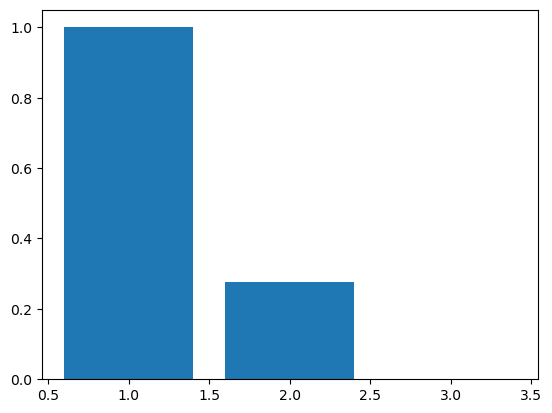

In [127]:
rel_error = pd.DataFrame(sites['median_peak_swe'] / sites['median_peak_swe'])
rel_error['soil_error'] = sites['soil_error'] / sites['median_peak_swe']
rel_error['veg_error'] = sites['veg_error'] / sites['median_peak_swe']

fig.add_axes([l, b, w, h])

fig, ax = plt.subplots()
ax.bar([1,2,3], rel_error.loc[12])

In [126]:
rel_error

0                                                           1.0
1                                                           1.0
2                                                           1.0
3                                                           1.0
4                                                           1.0
5                                                           1.0
6                                                           1.0
7                                                           1.0
8                                                           1.0
9                                                           1.0
10                                                          1.0
11                                                          1.0
12                                                          1.0
soil_error    0     0.025407
1     0.103637
2     0.051172
3...
veg_error     0     0.002518
1     0.000075
2     0.000000
3...
Name: median_peak_swe, dtype: object

In [122]:
sites['median_peak_swe']

0     2.09042
1     0.37338
2     1.10236
3     0.42926
4     0.35306
5     0.45720
6     0.54610
7     0.51308
8     0.54610
9     0.83820
10    0.66294
11    0.30480
12    0.18796
Name: median_peak_swe, dtype: float64

In [18]:
station_id = '653_OR_SNTL'
test = pd.read_csv(f'https://raw.githubusercontent.com/egagli/snotel_ccss_stations/main/data/{station_id}.csv',index_col='datetime', parse_dates=True)
test

,TAVG,TMIN,TMAX,SNWD,WTEQ,PRCPSA
datetime,,,,,,
1980-10-01,NaN,NaN,NaN,NaN,0.0,0.0102
1980-10-02,NaN,NaN,NaN,NaN,0.0,0.0000
1980-10-03,NaN,NaN,NaN,NaN,0.0,0.0000
1980-10-04,NaN,NaN,NaN,NaN,0.0,0.0000
1980-10-05,NaN,NaN,NaN,NaN,0.0,0.0000
...,...,...,...,...,...,...
2025-07-05,6.2,3.4,8.6,0.0000,0.0,0.0025
2025-07-06,6.1,1.9,11.6,0.0000,0.0,0.0051
2025-07-07,10.2,3.2,17.9,0.0000,0.0,0.0000
